# Most of the keyboards in smartphones give next word prediction features; google also uses next word prediction based on our browsing history. So a preloaded data is also stored in the keyboard function of our smartphones to predict the next word correctly. I will train a Deep Learning model for next word prediction using Python. I will use the Tensorflow and Keras library in Python for next word prediction model.

# For making a Next Word Prediction model, I will train a Recurrent Neural Network (RNN). So let’s start with this task now without wasting any time.

# ***Next Word Prediction Model***
# To start with our next word prediction model, let’s import some all the libraries we need for this task:

In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
path = '/content/1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


# Now I will split the dataset into each word in order but without the presence of some special characters.

In [3]:
tokenizer = RegexpTokenizer(r'w+')
words = tokenizer.tokenize(text)

# Now the next process will be performing the feature engineering in our data. For this purpose, we will require a dictionary with each word in the data within the list of unique words as the key, and it’s significant portions as value.

In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

# ***Feature Engineering***
# Here I will define a Word length which will represent the number of previous words that will determine our next word. I will define prev words to keep five previous words and their corresponding next words in the list of next words.

In [5]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['w', 'w', 'w', 'w', 'w']
www


# Now I will create two numpy arrays x for storing the features and y for storing its corresponding label. I will iterate x and y if the word is available so that the corresponding position becomes 1.

In [6]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [7]:
print(X[0][0])

[ True False]


# ***Building the Recurrent Neural network***
# As I stated earlier, I will use the Recurrent Neural networks for next word prediction model. Here I will use the LSTM model, which is a very powerful RNN.

In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# ***Training the Next Word Prediction Model***
# I will be training the next word prediction model with 20 epochs:

In [9]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


86/86 [==============================] - 4s 21ms/step - loss: 0.0146 - accuracy: 0.9999 - val_loss: 0.1636 - val_accuracy: 0.9844
Epoch 2/2
86/86 [==============================] - 1s 13ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.2158 - val_accuracy: 0.9844


# Now we have successfully trained our model, before moving forward to evaluating our model

In [10]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

# ***Evaluating the Next Word Prediction Model***
# Now let’s have a quick look at how our model is going to behave based on its accuracy and loss changes while training:

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

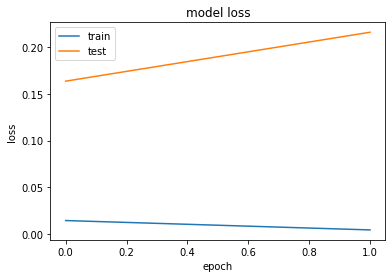

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# ***Testing Next Word Prediction Model***
# Now let’s build a python program to predict the next word using our trained model. For this, I will define some essential functions that will be used in the process.

In [13]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
prepare_input("This is an example of input for our LSTM".lower())

In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

# Now I will create a function to return samples:

In [16]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [17]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

# This function is created to predict the next word until space is generated. It will do this by iterating the input, which will ask our RNN model and extract instances from it. Now I will modify the above function to predict multiple characters:

In [18]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [19]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()